# Mesh generation/refinement for real glacier geometry

We use several datasets to create a mesh of Luggye glacier, which is refined near the terminus to eventually accommodate calving physics. This is based on an already-created .exp file describing a polygon for Luggye's outline (obtained as the intersection of the RGI outline with our own DEM). We have also manually delineated Luggye's terminus position from the date most closely aligning with the DEM (DEM from 18 October, 2025, terminus from 20 October). After meshing the outline, we refine based on distance from the terminus. 

In [1]:
######################
### issm functions ###
######################

from model import model
from bamg import bamg
from expread import expread

######################
### python modules ###
######################

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from shapely import LineString, contains_xy as contains
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points, split

data_dir = '/home/mielebzu/data/'
dem_dir = data_dir + 'dems'
dem_file = dem_dir + '/luggye_2025_ds.tif'
exp_dir = data_dir + 'exp_files'
os.chdir(exp_dir)

could not import shapefile, PyShp has not been installed, no shapefile reading capabilities enabled


## Initialize the model

In [2]:
min_cellsize, max_cellsize = 50, 50 #in metres
refined = 20 #size of the refined mesh cells

md = model()
md = bamg(md, 'domain', 'DomainOutline_20260126_162319.exp', 'hmax', max_cellsize, 'hmin', min_cellsize)

At least one contour was not correctly oriented and has been re-oriented


## Load the terminus curve

...and extend it so that it reaches the edges of the domain. 

In [3]:
terminus = LineString([ #copy/pasted from GEEDiT
    (90.31877330330583, 28.09807611129586),
    (90.31919172791216, 28.098104504384743),
    (90.31958869484636, 28.0979909319842),
    (90.31985691574785, 28.09783950192981),
    (90.32003930596086, 28.097602892042097),
    (90.32007149246904, 28.097356817205473),
    (90.3201358654854, 28.097176992929565),
    (90.32029679802629, 28.096940381581167),
    (90.32055429009172, 28.09669430522543),
    (90.32076886681291, 28.096438763797273),
    (90.32100490120622, 28.096154828163456),
    (90.32110146073076, 28.095889820894154),
    (90.32110146073076, 28.095539631713223),
    (90.32101563004228, 28.095113724412702)
])

terminus_gdf = gpd.GeoSeries([terminus], crs = 'EPSG:4326').to_crs(epsg = 32645) #reproject 
terminus = terminus_gdf.iloc[0]

contours = expread(exp_dir + '/DomainOutline_20260126_162319.exp')
Ω = Polygon(zip(contours[0]['x'], contours[0]['y'])) #the domain outline

def extend(linestring, polygon, ε = 1e-10): #this function takes a linestring and extends either endpoint to the encompassing polygon

    if not polygon.covers(linestring):
        print('LineString extends beyond meshed domain. Consider trimming instead.')
        return linestring

    p_0, p_n = Point(linestring.coords[0]), Point(linestring.coords[-1])
    Ω_0, Ω_n = nearest_points(p_0, polygon.boundary)[1], nearest_points(p_n, polygon.boundary)[1] #find the nearest points on Ω
    p_0, p_n = np.asarray(p_0.coords), np.asarray(p_n.coords)
    Ω_0, Ω_n = np.asarray(Ω_0.coords), np.asarray(Ω_n.coords)
    d_0, d_n = (Ω_0 - p_0)/np.linalg.norm(Ω_0 - p_0), (Ω_n - p_n)/np.linalg.norm(Ω_n - p_n)
    Ω_0, Ω_n = Ω_0 + ε*d_0, Ω_n + ε*d_n #and extend slightly beyond the boundary
    
    coords = [(Point(Ω_0).x, Point(Ω_0).y), *list(linestring.coords), (Point(Ω_n).x, Point(Ω_n).y)] #incorporate as new linestring coords
    return LineString(coords)
        
terminus = extend(terminus, Ω)

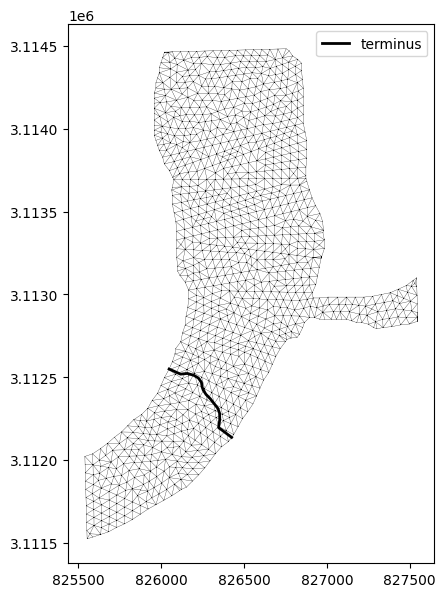

In [4]:
mx, my = md.mesh.x, md.mesh.y
elts = md.mesh.elements - 1
tx, ty = np.array(terminus.coords).T

plt.figure(figsize = (7, 7))
plt.triplot(mx, my, elts, color = 'k', linewidth = 0.2)
plt.plot(tx, ty, 'k-', linewidth = 2, label = 'terminus')
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

## Create criterion for refinement

We will write a scalar field which has its largest values close to the terminus LineString, and approaches zero far away from it. 

In [5]:
d = np.array([terminus.distance(Point(xi, yi)) for xi, yi in zip(md.mesh.x, md.mesh.y)]) #distances from terminus, for each mesh node
L = 50 #half-width of the zone of increased refinement (metres from the terminus)
d = np.exp(-(d/L)**2) #cornert "d" into an exponential which peaks close to the terminus
md = bamg(md, 'field', d, 'err', 1e-3, 'hmin', refined, 'hmax', max_cellsize) #good value for "err" obtained by brute force

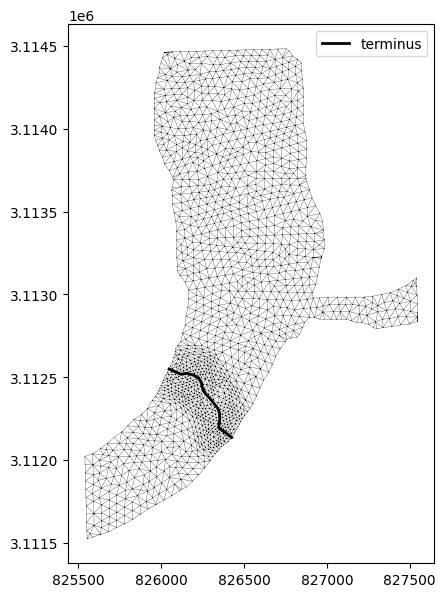

In [6]:
mx, my = md.mesh.x, md.mesh.y #redefine for new mesh
elts = md.mesh.elements - 1

plt.figure(figsize = (7, 7))
plt.triplot(mx, my, elts, color = 'k', linewidth = 0.2)
plt.plot(tx, ty, 'k-', linewidth = 2, label = 'terminus')
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

## Separate the domain into ice and water

This part is the problem for tomorrow. Currently most boundary points are not selected into either domain. Likely because the mesh is finer than the polygon itself - many boundary points fall just outside the polygon. Maybe we can fix this by redefining the polygon to exactly coincide with the mesh boundary. Or something like that... 

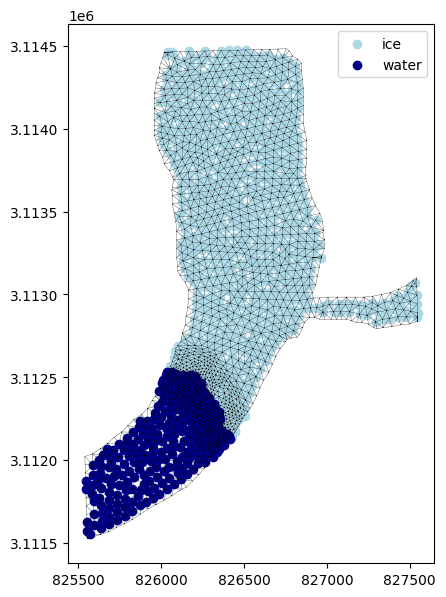

In [7]:
parts = split(Ω, terminus)
Ω_1, Ω_2 = parts.geoms

ice_mask = contains(Ω_1, mx, my)
lake_mask = contains(Ω_2, mx, my)
md.mask.ice_mask = ice_mask.copy()
md.mask.ocean_mask = lake_mask.copy()

fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(mx[ice_mask], my[ice_mask], color = 'lightblue', label = 'ice')
ax.scatter(mx[lake_mask], my[lake_mask], color = 'darkblue', label = 'water')
ax.triplot(mx, my, elts, linewidth=0.2, color='k')
plt.legend()
ax.set_aspect('equal')
plt.show()

## Bonus: interpolate DEM data

Open DEM data and project onto mesh points. 

In [8]:
import rasterio

with rasterio.open(dem_file) as src:
    z = src.read(1).astype(float)
    t = src.transform

col, row = (~t*(mx, my))
col = col.astype(int)
row = row.astype(int)

dem_on_mesh = z[row, col]

waterline = 4500
dem_on_mesh[np.where(np.isnan(dem_on_mesh))] = waterline #for now, set nans to waterline level
dem_on_mesh[dem_on_mesh < waterline] = waterline #and anything below waterline level as well
md.geometry.surface = dem_on_mesh #this can be the surface 

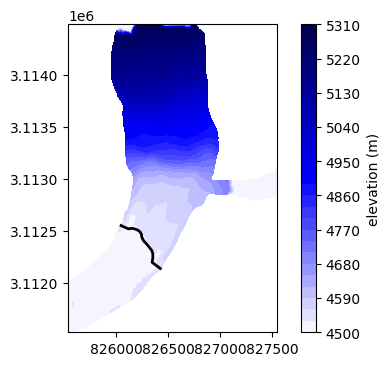

In [9]:
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vcenter = waterline)

plt.figure(figsize = (6, 4))
plt.tricontourf(mx, my, elts, md.geometry.surface, levels = 30, cmap = 'seismic_r', norm = norm)
plt.plot(tx, ty, 'k-', linewidth = 2, label = 'terminus')
plt.colorbar(label = 'elevation (m)')
plt.gca().set_aspect('equal')
plt.show()